<a href="https://colab.research.google.com/github/SoumyaTeotia/Text-Based-Gene-Mutation-Classification-for-Enhanced-Cancer-Tumor-Detection/blob/main/Text_based_gene_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_text= pd.read_csv('drive/MyDrive/nlp_dataset/training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])

train_variants= pd.read_csv('drive/MyDrive/nlp_dataset/training_variants')

In [ ]:
print(train_text.shape)
print(train_variants.shape)

(3321, 2)
(3321, 4)


In [ ]:
train = pd.merge(train_variants,train_text, how='left', on='ID')

In [ ]:
train.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

In [ ]:
df_train=train.dropna(axis=0).copy()
df_train.shape

(3316, 5)

In [ ]:
df_train.head

<bound method NDFrame.head of         ID    Gene             Variation  Class  \
0        0  FAM58A  Truncating Mutations      1   
1        1     CBL                 W802*      2   
2        2     CBL                 Q249E      2   
3        3     CBL                 N454D      3   
4        4     CBL                 L399V      4   
...    ...     ...                   ...    ...   
3316  3316   RUNX1                 D171N      4   
3317  3317   RUNX1                 A122*      1   
3318  3318   RUNX1               Fusions      1   
3319  3319   RUNX1                  R80C      4   
3320  3320   RUNX1                  K83E      4   

                                                   Text  
0     Cyclin-dependent kinases (CDKs) regulate a var...  
1      Abstract Background  Non-small cell lung canc...  
2      Abstract Background  Non-small cell lung canc...  
3     Recent evidence has demonstrated that acquired...  
4     Oncogenic mutations in the monomeric Casitas B...  
...      

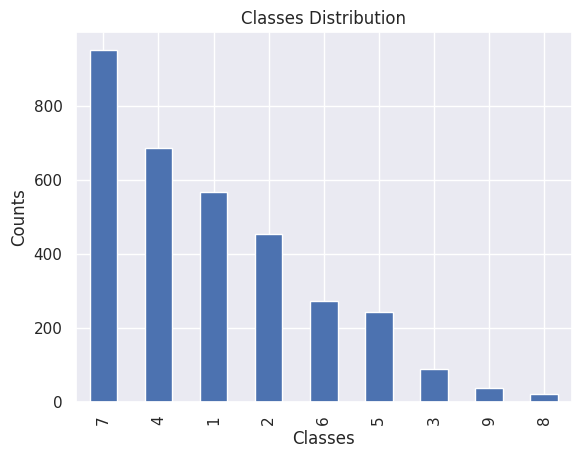

In [ ]:
df_train.Class.value_counts().plot(kind="bar",title='Classes Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

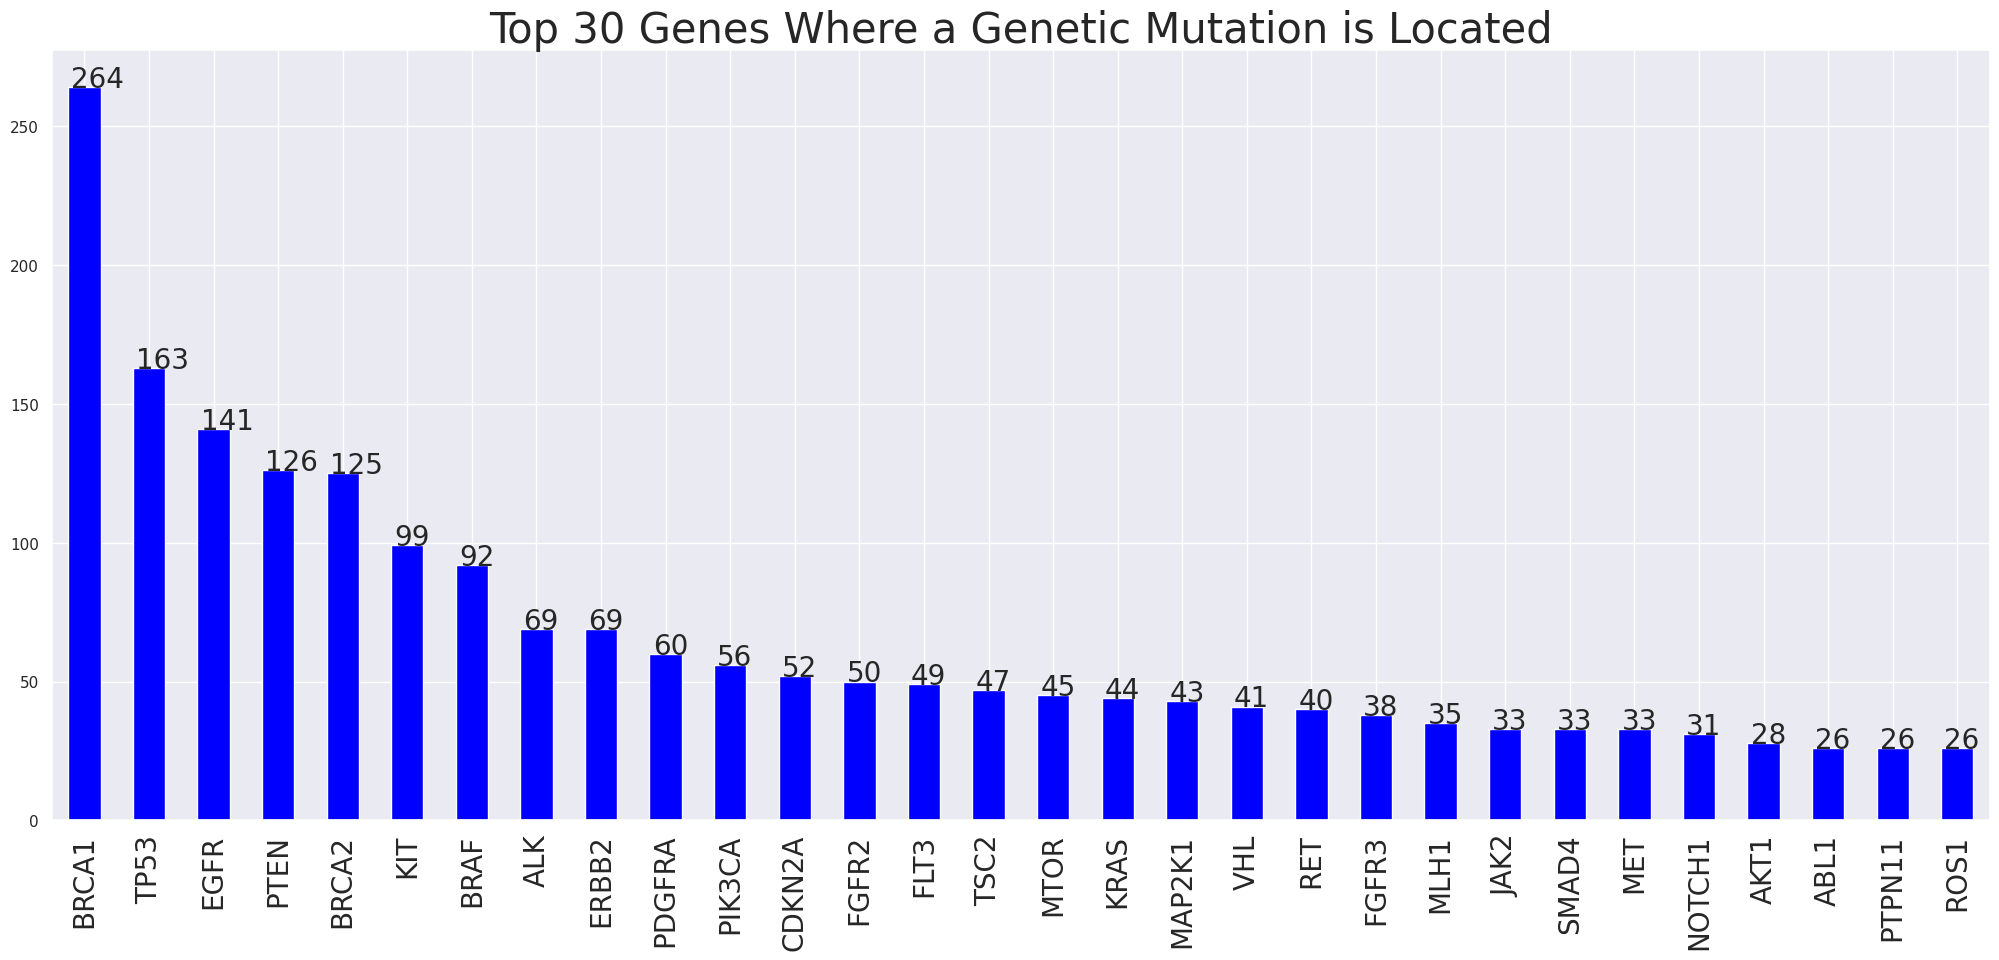

In [ ]:
# Plot top 30 the frequency of the gene where this genetic mutation is located
df_train.Gene.value_counts()[:30].plot(kind='bar',figsize=(25,10),color='blue')
plt.xticks(fontsize=20)
plt.title("Top 30 Genes Where a Genetic Mutation is Located",fontsize=30)
for i in range(0,30):
    plt.text(i-0.2,df_train.Gene.value_counts()[:30][i],"{}".format(df_train.Gene.value_counts()[:30][i]),fontsize=20)

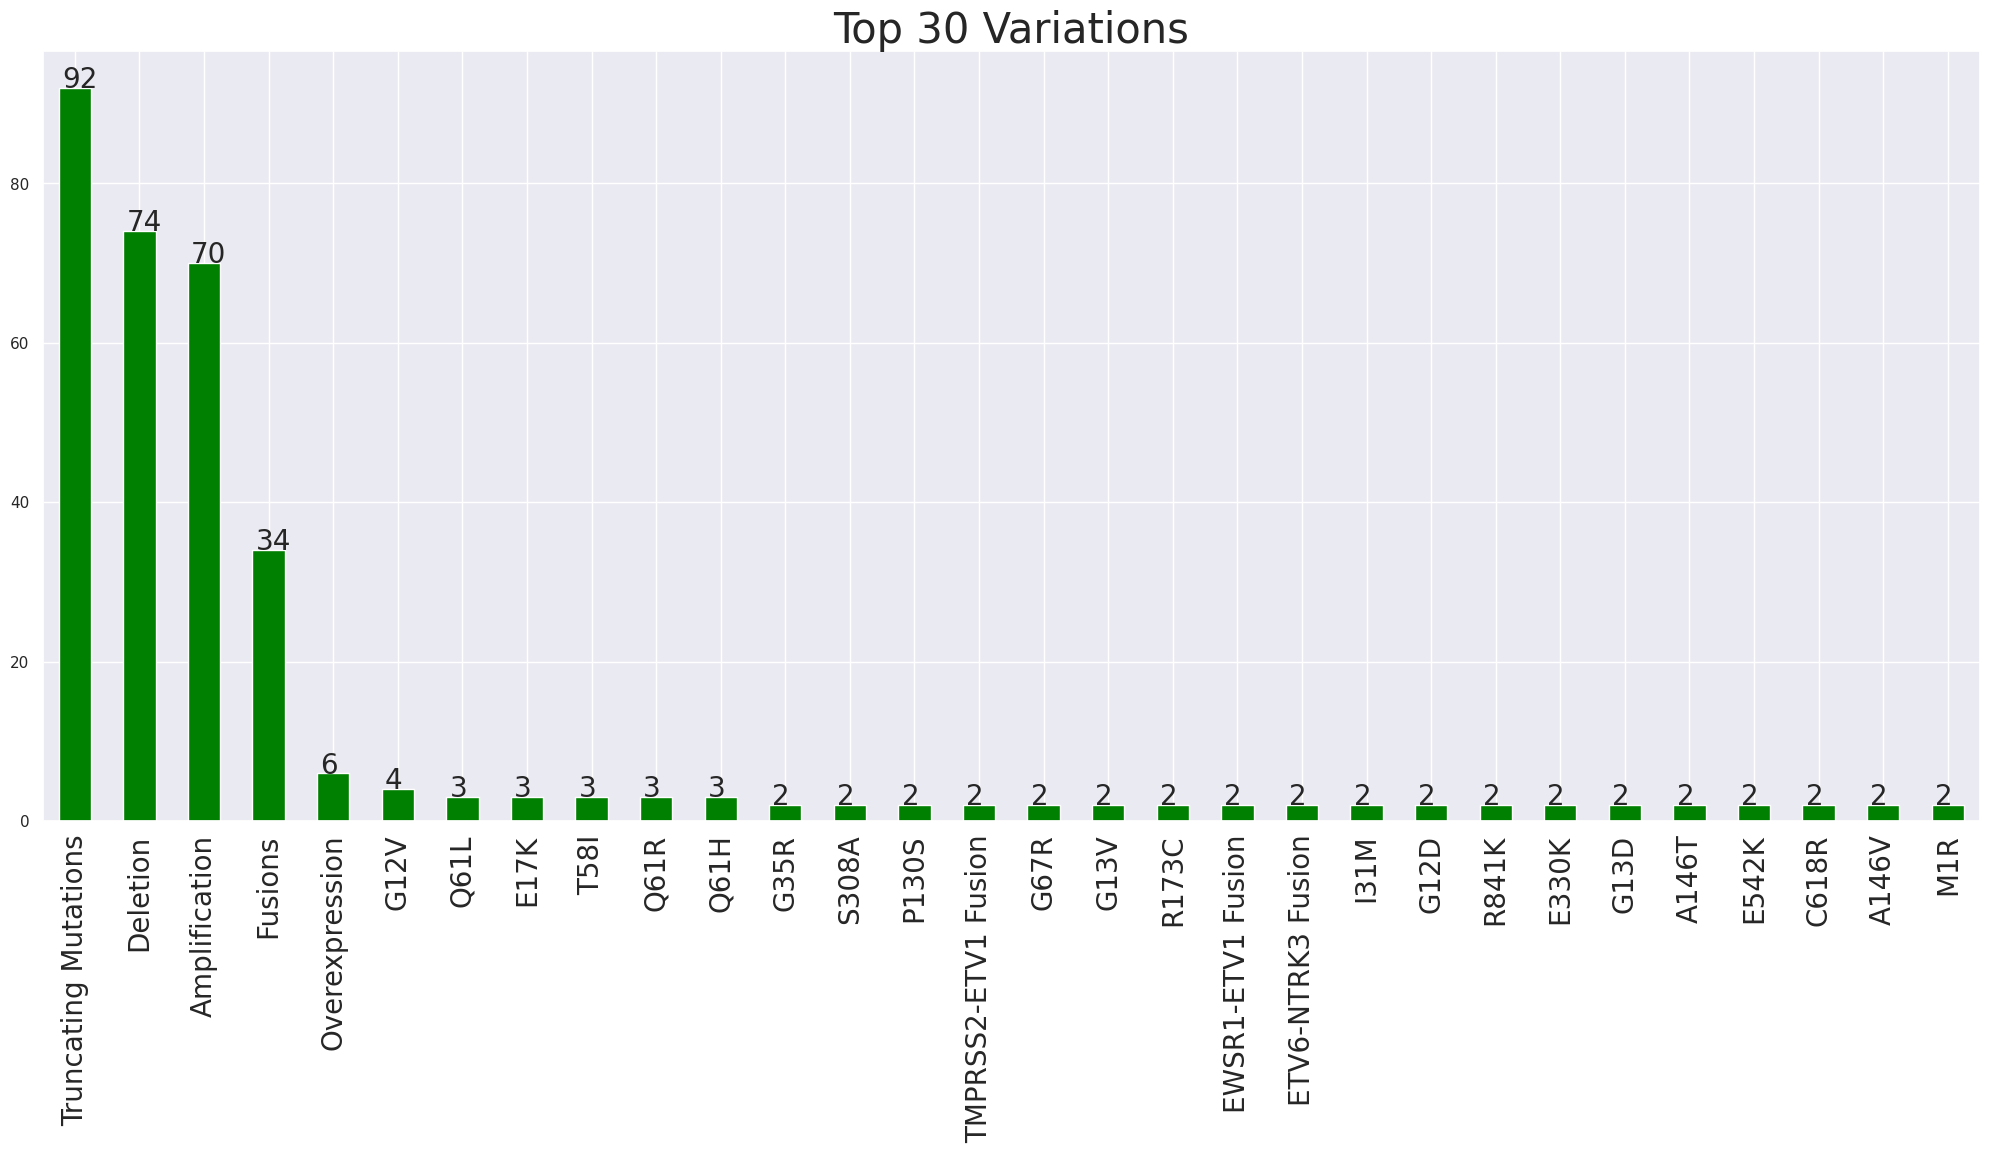

In [ ]:
df_train.Variation.value_counts()[:30].plot(kind='bar',figsize=(25,10),color='green')
plt.xticks(fontsize=20)
plt.title("Top 30 Variations",fontsize=30)
for i in range(0,30):
    plt.text(i-0.2,df_train.Variation.value_counts()[:30][i],"{}".format(df_train.Variation.value_counts()[:30][i]),fontsize=20)

# Data Engineering

In [ ]:
import re, string
from nltk.corpus import stopwords
import nltk

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Create functions for tokenization, stemming, lemmatization and
# finally combine all functions together to obtain cleaned_text_date for train and test data


sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',"'", '©',
'said',"'s", "also",'one',"n't",'com', 'satirewire', '-', '–', "et al",
'—', '_','et al ',"/"]
sw_set = set(sw_list)

# tokenization
def process_review(review):
    tokens = nltk.word_tokenize(review) # tokenization
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]# stop words removal
    return stopwords_removed

# Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()
# create a function stemming() and loop through each word in a review
def stemming(review):
    stemmed_review=[]
    for w in review:
        stemmed_review.append(ps.stem(w))
    return stemmed_review

# import libraries
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# create a function and loop through each word in a review
def lemmatization(review):
    lemma_list=[]
    for word in review:
        lemma_word=lemmatizer.lemmatize(word,pos='v')
        lemma_list.append(lemma_word)
    return lemma_list


def data_preprocessing(review):
    #tokenization, stop words removal, punctuation marks removal
    processed_review=list(map(process_review,review))
    # stemming
    stemming_reviews=list(map(stemming,processed_review))
    # lemmatization
    lemma_reviews=list(map(lemmatization,stemming_reviews))
    return lemma_reviews

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
cleaned_train_text=data_preprocessing(df_train['Text'])

In [ ]:
import pickle
pickle_out1=open('cleaned_train_text', 'wb')
pickle.dump(cleaned_train_text, pickle_out1)
pickle_out1.close()

In [ ]:
import pickle
pickle_in_train = open("cleaned_train_text","rb")
cleaned_train_text = pickle.load(pickle_in_train)


# N Grams

In [ ]:
df_train['cleaned_text']=[" ".join(i) for i in cleaned_train_text]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


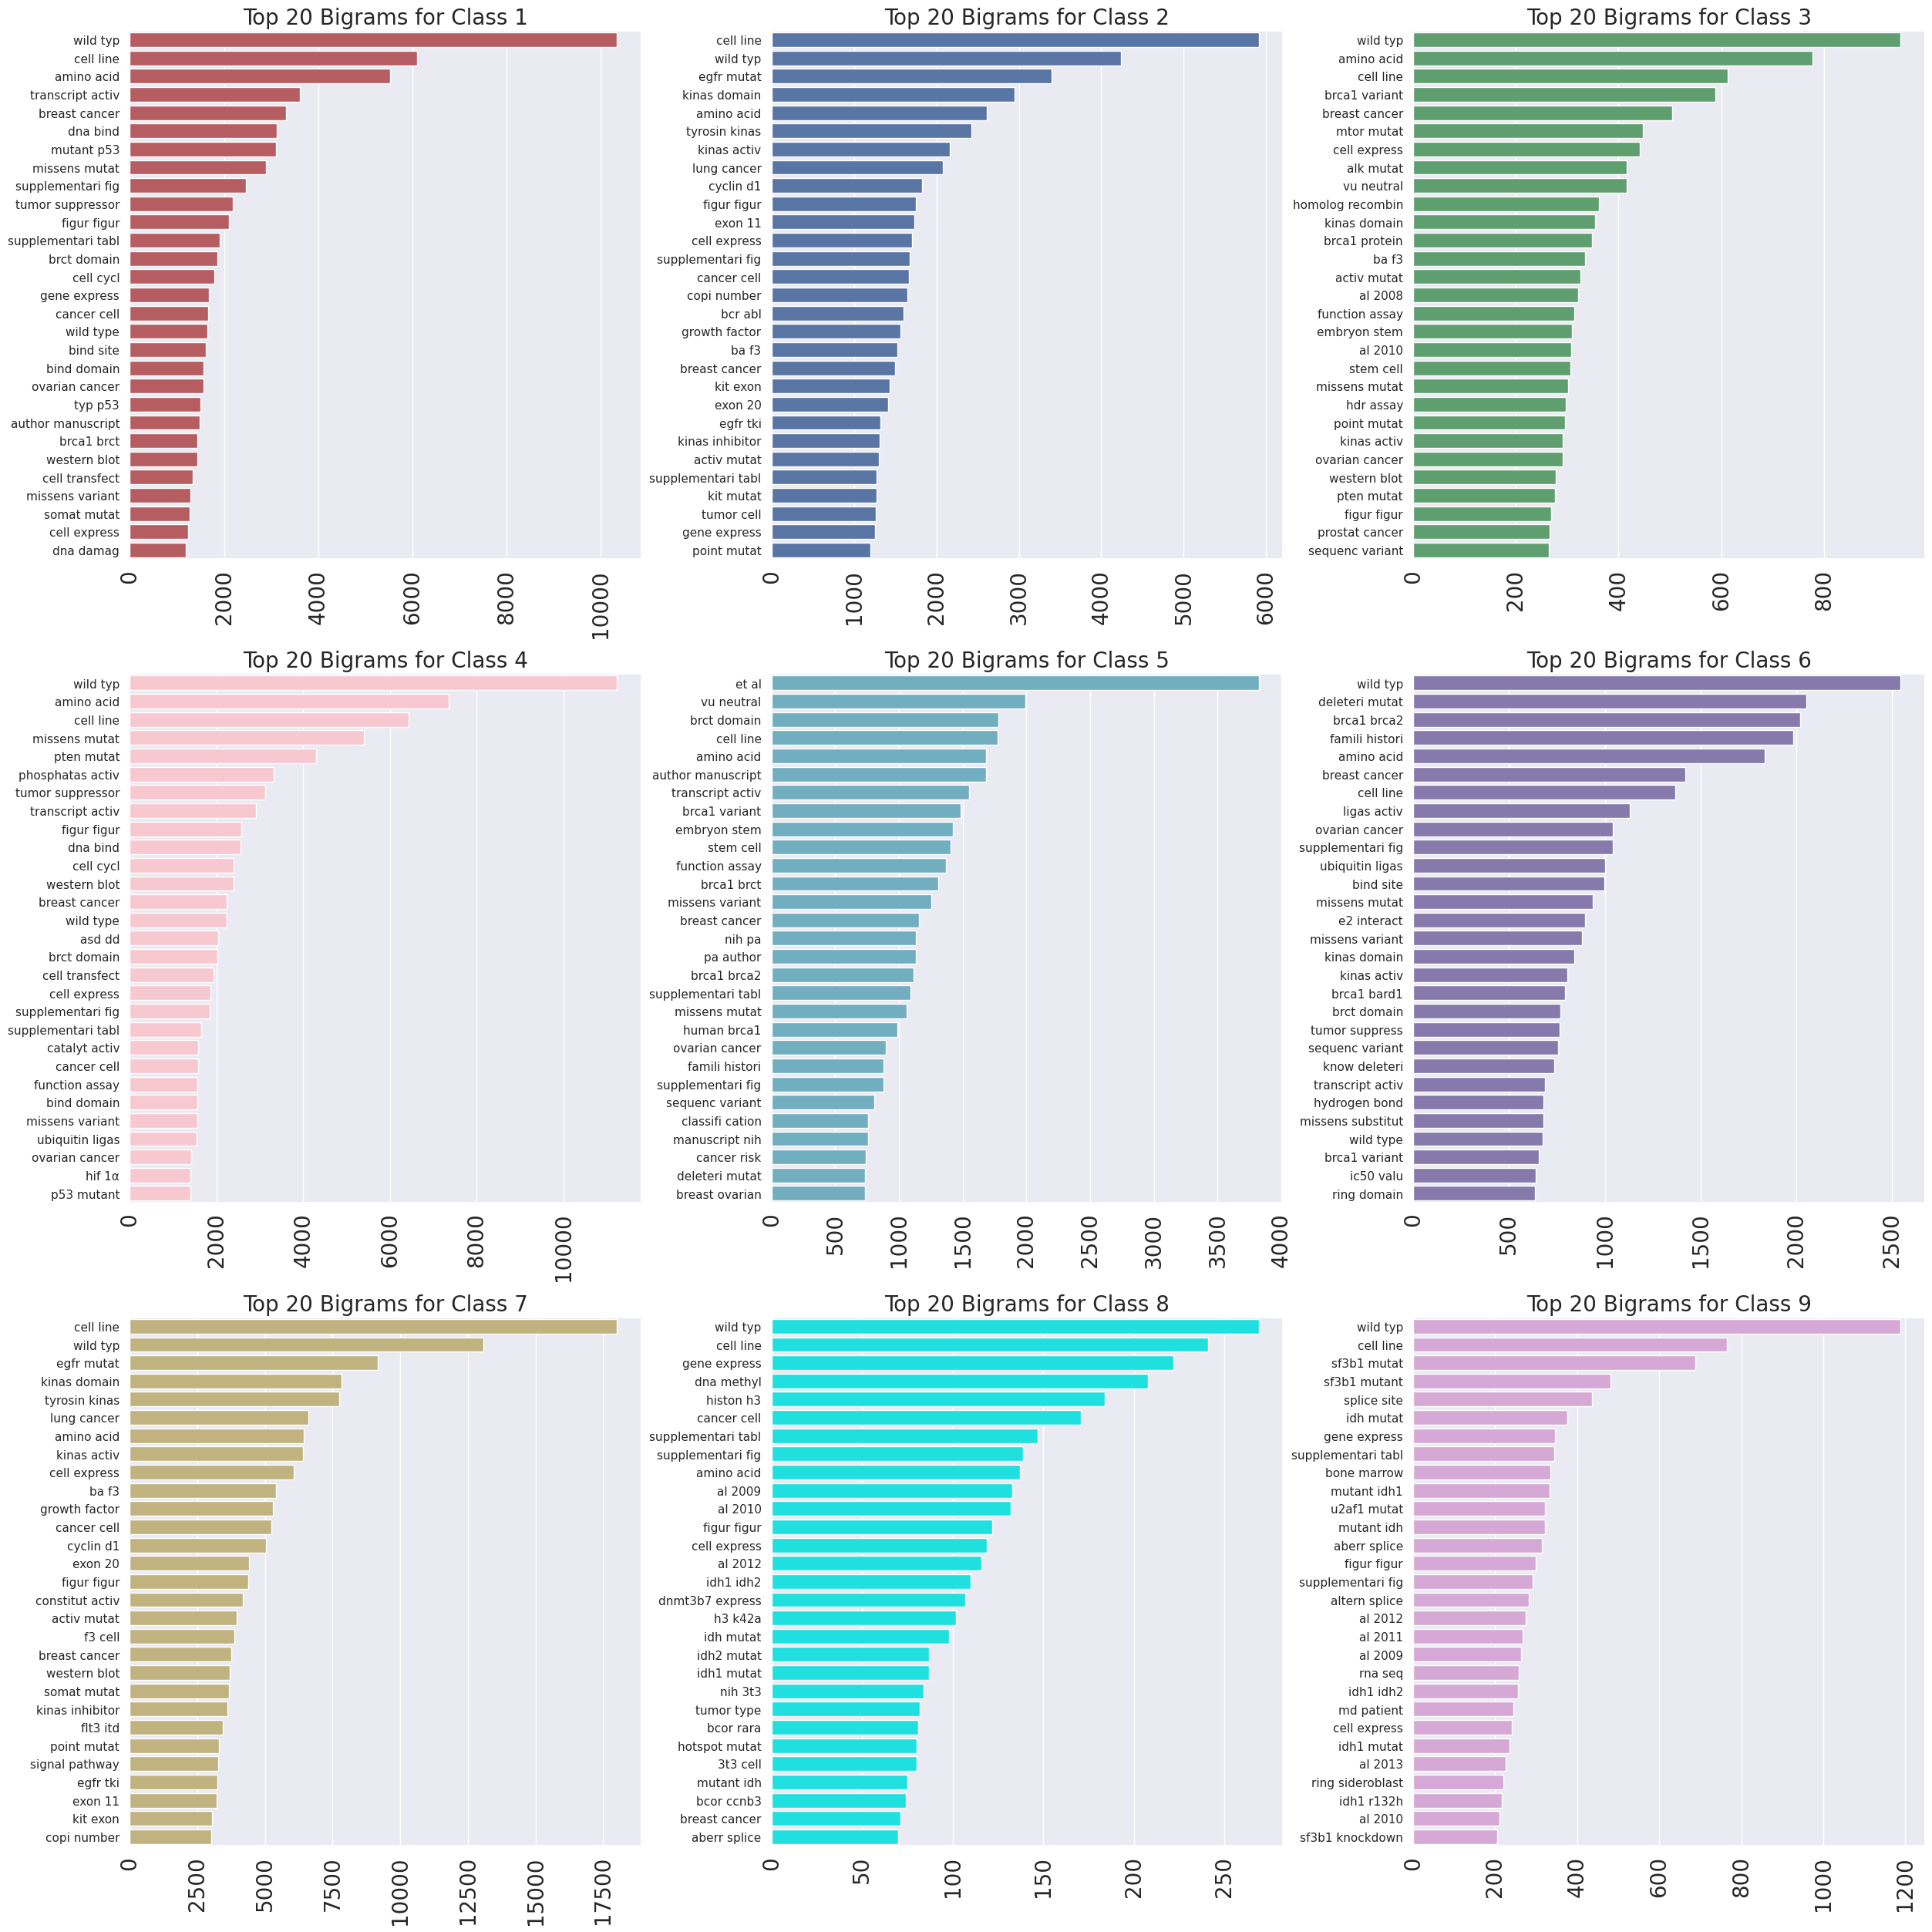

In [ ]:
class1 = get_top_n_bigram(df_train[df_train['Class']==1]['cleaned_text'], 30)
class2=  get_top_n_bigram(df_train[df_train['Class']==2]['cleaned_text'], 30)
class3 = get_top_n_bigram(df_train[df_train['Class']==3]['cleaned_text'], 30)
class4 = get_top_n_bigram(df_train[df_train['Class']==4]['cleaned_text'], 30)
class5 = get_top_n_bigram(df_train[df_train['Class']==5]['cleaned_text'], 30)
class6 = get_top_n_bigram(df_train[df_train['Class']==6]['cleaned_text'], 30)
class7 = get_top_n_bigram(df_train[df_train['Class']==7]['cleaned_text'], 30)
class8 = get_top_n_bigram(df_train[df_train['Class']==8]['cleaned_text'], 30)
class9 = get_top_n_bigram(df_train[df_train['Class']==9]['cleaned_text'], 30)

classes_data=[class1[1:],class2[1:],class3[1:],class4[1:],class5[1:],
              class6[1:],class7[1:],class8[1:],class9[1:]]
colors=['r','b','g','pink','c','m','y','aqua','plum']

plt.figure(figsize=(25,25))
for i in range(0,9):
    plt.subplot(3,3,i+1)
    x=[x[0] for x in classes_data[i]]
    y=[x[1] for x in  classes_data[i]]
    sns.barplot(x=y,y=x,color=colors[i])
    plt.xticks(rotation=90,fontsize=20)
    plt.title("Top 20 Bigrams for Class {}".format(i+1),fontsize=20)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [ ]:
# Trigrams
def get_top_n_ngram(corpus, n=None,k=None):
    vec = CountVectorizer(ngram_range=(k,k )).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
class1t = get_top_n_ngram(df_train[df_train['Class']==1]['cleaned_text'], 30,5)
class2t = get_top_n_ngram(df_train[df_train['Class']==2]['cleaned_text'], 30,5)
class3t = get_top_n_ngram(df_train[df_train['Class']==3]['cleaned_text'], 30,5)
class4t = get_top_n_ngram(df_train[df_train['Class']==4]['cleaned_text'], 30,5)
class5t = get_top_n_ngram(df_train[df_train['Class']==5]['cleaned_text'], 30,5)
class6t = get_top_n_ngram(df_train[df_train['Class']==6]['cleaned_text'], 30,5)
class7t = get_top_n_ngram(df_train[df_train['Class']==7]['cleaned_text'], 30,5)
class8t = get_top_n_ngram(df_train[df_train['Class']==8]['cleaned_text'], 30,5)
class9t = get_top_n_ngram(df_train[df_train['Class']==9]['cleaned_text'], 30,5)

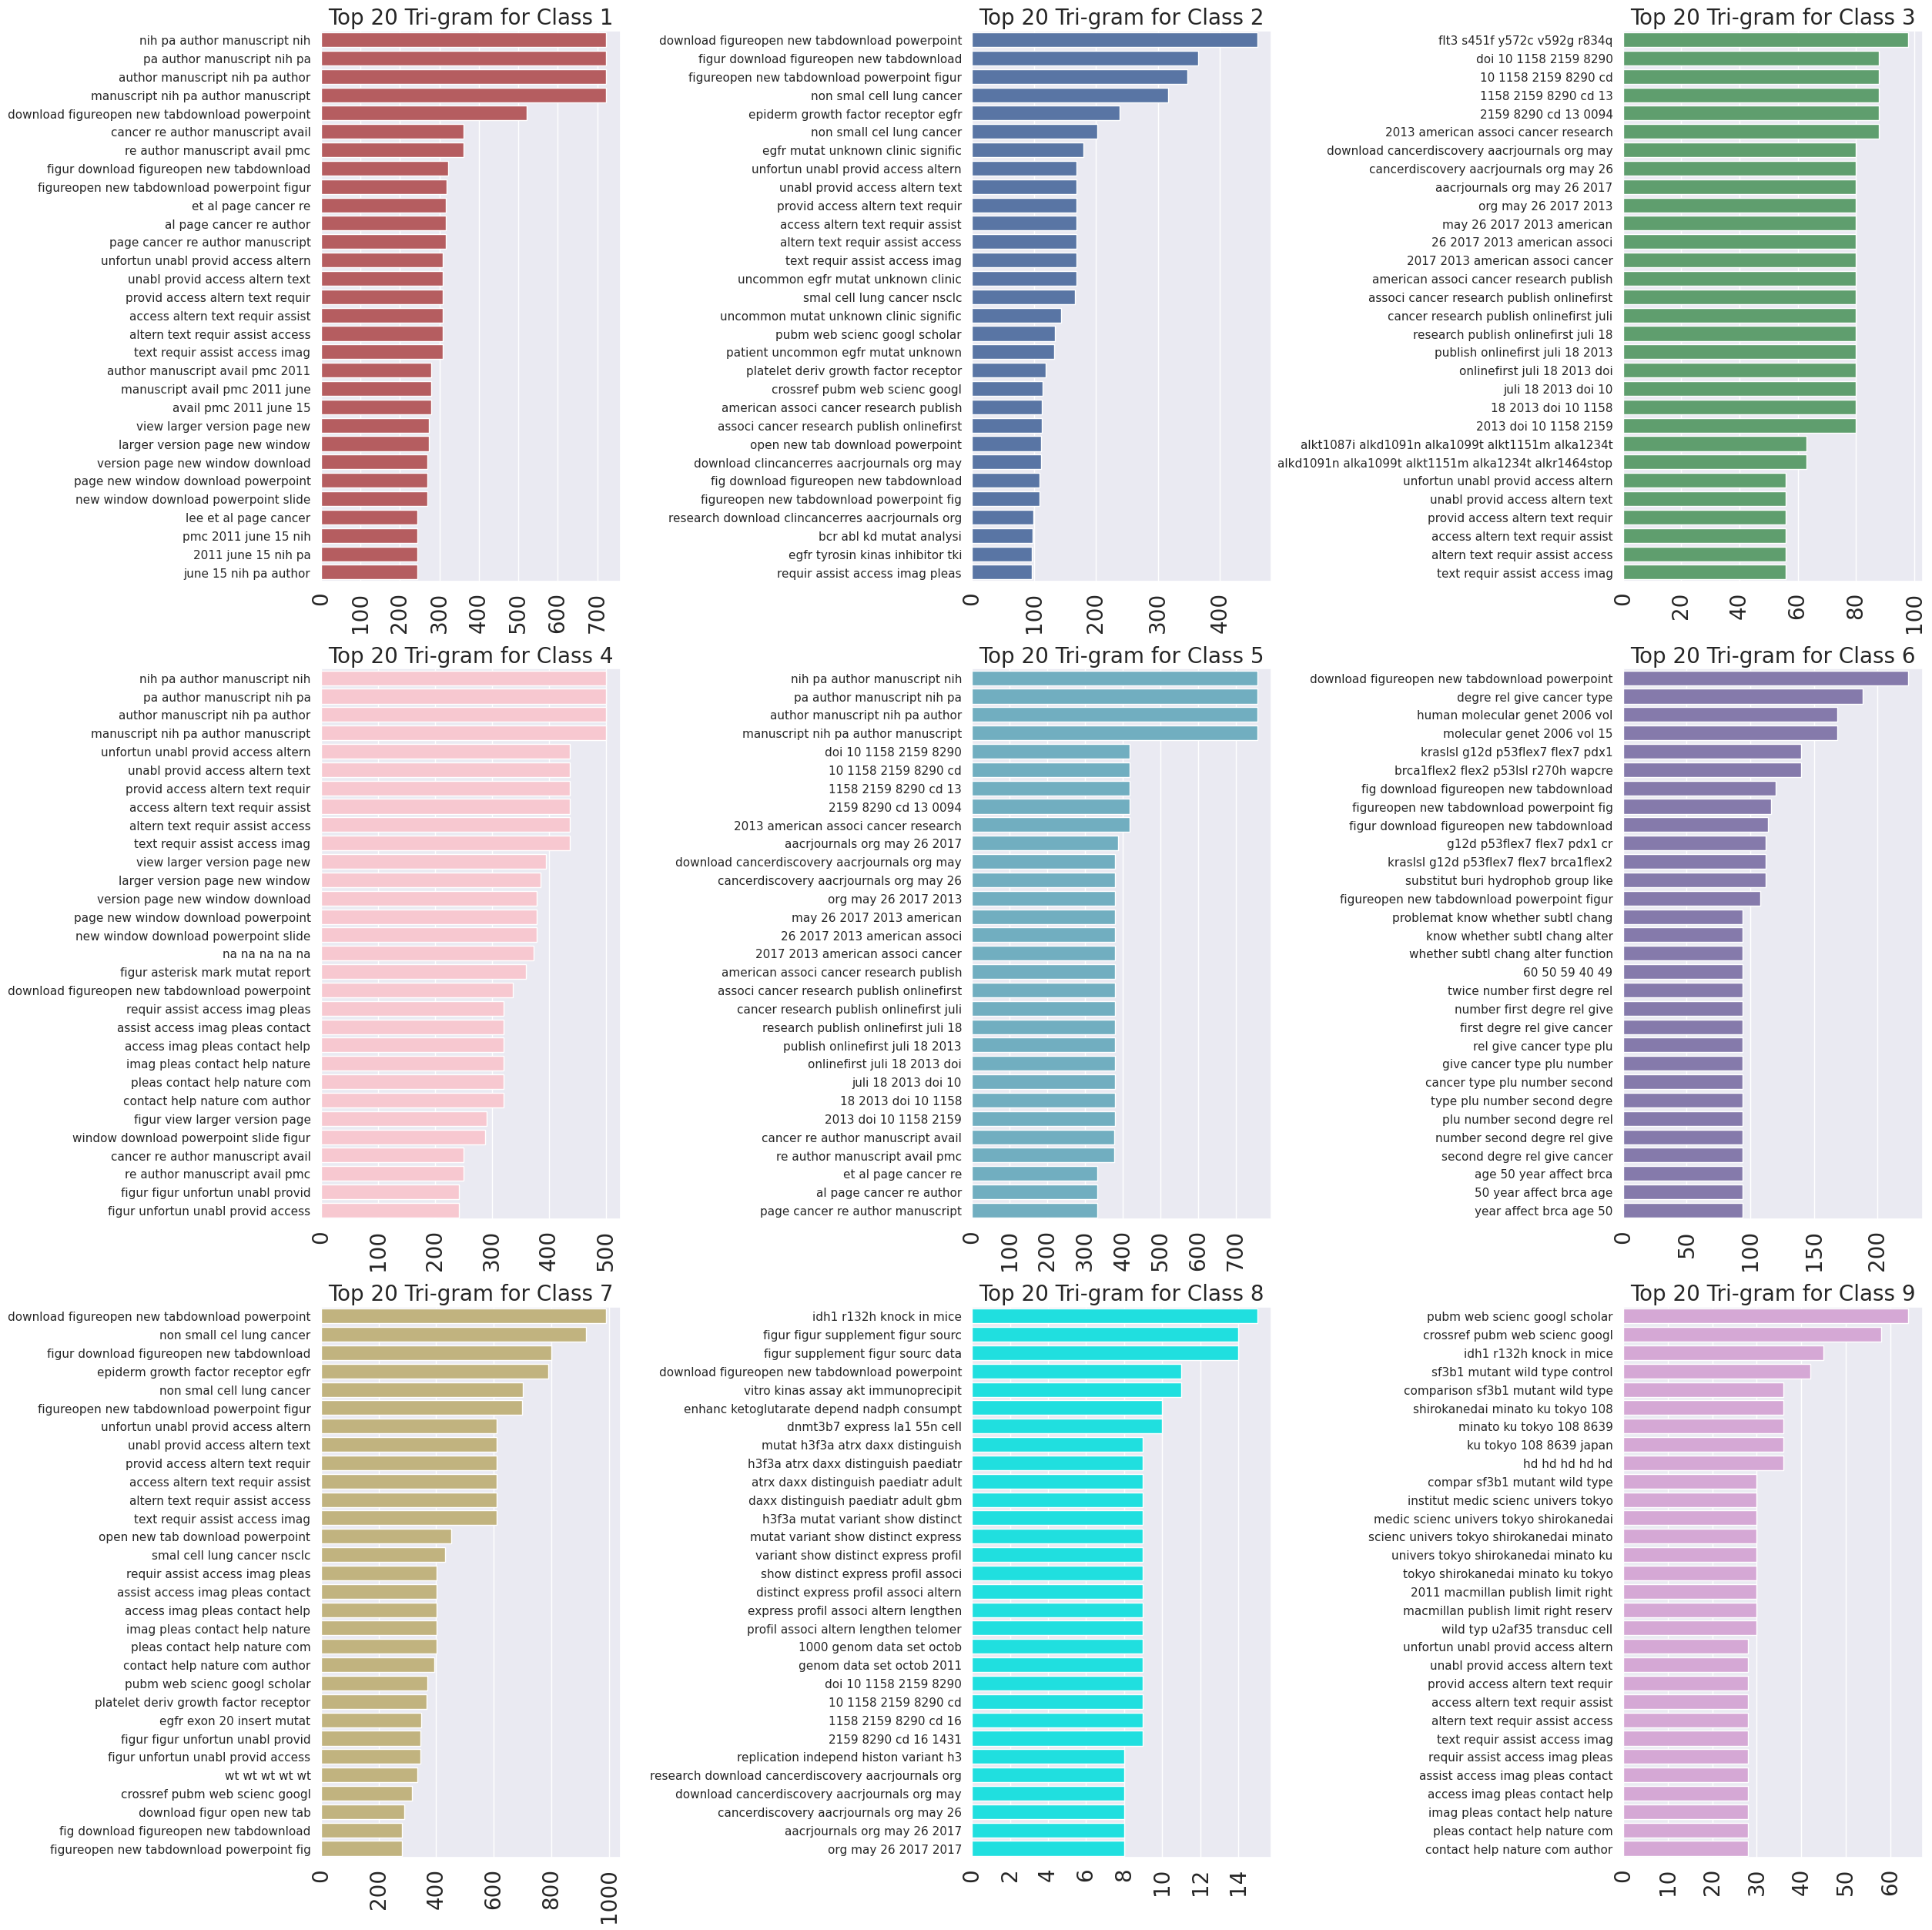

In [ ]:
classest_data=[class1t,class2t,class3t,class4t,class5t,
              class6t,class7t,class8t,class9t]
plt.figure(figsize=(25,25))
# good reviews bigrams
for i in range(0,9):
    plt.subplot(3,3,i+1)
    x=[x[0] for x in classest_data[i]]
    y=[x[1] for x in  classest_data[i]]
    sns.barplot(x=y,y=x,color=colors[i])
    plt.xticks(rotation=90,fontsize=20)
    plt.title("Top 20 Tri-gram for Class {}".format(i+1),fontsize=20)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [ ]:
#declare inputs and target
inputs=df_train[['ID', 'Gene', 'Variation','cleaned_text']]
target=df_train.Class

In [ ]:
training  = pd.DataFrame()
training[list(inputs.columns)]=inputs
training['target']=target
training.head()

,ID,Gene,Variation,cleaned_text,target
0,0,FAM58A,Truncating Mutations,cyclin-depend kinas cdk regul varieti fundamen...,1
1,1,CBL,W802*,abstract background non-smal cell lung cancer ...,2
2,2,CBL,Q249E,abstract background non-smal cell lung cancer ...,2
3,3,CBL,N454D,recent evid demonstr acquir uniparent disomi a...,3
4,4,CBL,L399V,oncogen mutat monomer casita b-lineag lymphoma...,4


In [ ]:
classes_list=[]
for i in range(0,9):
    class_i= training[training.target==i+1]
    classes_list.append(class_i)
    print("Class {}: ".format(i+1)+str(len(class_i)))

Class 1: 566
Class 2: 452
Class 3: 89
Class 4: 686
Class 5: 242
Class 6: 273
Class 7: 952
Class 8: 19
Class 9: 37


In [ ]:
# upsample minority
def oversampling(majority,minority):
    minority_upsampled = resample(minority,
                              replace=True, # sample with replacement
                              n_samples=len(majority), # match number in majority class
                              random_state=365) # reproducible results
    return minority_upsampled

In [ ]:
classes_list.pop(-3)# remove class 7 dataset

,ID,Gene,Variation,cleaned_text,target
28,28,TERT,C228T,sequenc studi identifi mani recurr code mutat ...,7
31,31,TERT,Promoter Mutations,sequenc studi identifi mani recurr code mutat ...,7
34,34,TERT,C250T,sequenc studi identifi mani recurr code mutat ...,7
67,67,RHEB,Y35C,gene encod compon pi3k-akt-mtor signal axi fre...,7
68,68,RHEB,Y35N,gene encod compon pi3k-akt-mtor signal axi fre...,7
...,...,...,...,...,...
3292,3292,RET,C634Y,investigatedth transformingactivityofth ret pr...,7
3294,3294,RET,R886W,introduct inherit germ line activ mutat rearra...,7
3296,3296,RET,Y791F,ret proto-oncogen encod receptor tyrosin kinas...,7
3308,3308,RUNX1,R174*,famili platelet disord propens acut myeloid le...,7


In [ ]:
len(classes_list)

8

In [ ]:
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


upsampled_classes_list=[]
for cla in classes_list:
    upsample_df=oversampling(training[training.target==7],cla)
    upsampled_classes_list.append(upsample_df)

In [ ]:
class_7df=training[training.target==7]
upsampled_classes_list.append(class_7df)

In [ ]:
# combine majority and upsampled minority
upsampled=pd.concat(upsampled_classes_list)
# check new class counts
upsampled.target.value_counts(),len(upsampled_classes_list)

(1    952
 2    952
 3    952
 4    952
 5    952
 6    952
 8    952
 9    952
 7    952
 Name: target, dtype: int64,
 9)

In [ ]:
# declare target and inputs
target = upsampled.target
inputs= upsampled.drop(columns=['ID','target'], axis=1)

In [ ]:
inputs.columns

Index(['Gene', 'Variation', 'cleaned_text'], dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=.2)

# Data Vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def vectorizer(train,test):
    vectorizer=CountVectorizer()
    new_train=vectorizer.fit_transform(train)
    new_test=vectorizer.transform(test)
    return new_train,new_test

In [ ]:
gene_train,gene_test=vectorizer(x_train.Gene,x_test.Gene)
variation_train,variation_test=vectorizer(x_train.Variation,x_test.Variation)
#cleaned_text_train,cleaned_text_test=vectorizer(x_train.cleaned_text,x_test.cleaned_text)

# TF-IDF for medical text data
TF-IDF (Term Frequency-Inverse Document Frequency) is used for medical text as it extracts essential terms, emphasizes important words unique to a document, reduces noise in medical jargon, and aids in tasks like disease prediction and patient condition analysis

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Fit and transform on training data
tfidf_train = tfidf_vectorizer.fit_transform(x_train['cleaned_text'])

# Transform test data using the same vectorizer
tfidf_test = tfidf_vectorizer.transform(x_test['cleaned_text'])



# ML models

## Naive Bayes

In [ ]:
# Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score,make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
f1 = make_scorer(f1_score , average='weighted')

def NB_GridSearch(X_train, y_train):
    grid_params = {'alpha':[0.1,0.2,0.3,0.4,0.5],
                     'fit_prior': [True, False],  }

    gs = GridSearchCV( MultinomialNB(), grid_params,scoring=f1, cv=10)
    gs.fit(X_train, y_train)
    print("Best Score: ", gs.best_score_)
    print("Best Alpha: ", gs.best_params_)

    return gs.best_params_.values()


def NaiveBayes(X_train,y_train,X_test,y_test,alpha,fit_prior):
    # fit the training dataset on the NB classifier
    Naive = MultinomialNB(alpha=0.1, fit_prior= True)
    Naive.fit(X_train,y_train)
    #prediction
    nb_train_pre=Naive.predict(X_train)
    nb_test_pre=Naive.predict(X_test)
    # Use accuracy_score function to get the accuracy
    print("Naive Bayes Train Accuracy Score :",accuracy_score(nb_train_pre, y_train))
    print("Naive Bayes Test Accuracy Score :",accuracy_score(nb_test_pre, y_test))
    # calculate f1 scores for test data and train data
    nb_f1_score_test=f1_score(y_test,nb_test_pre,average='weighted')
    nb_f1_score_train=f1_score(y_train,nb_train_pre,average='weighted')
    print("Train data f1 score:{}".format(nb_f1_score_train))
    print("Test data f1 score:{}".format(nb_f1_score_test ))
    print("confusion_matrix:{}".format(confusion_matrix(y_test, nb_test_pre)))
    print('==================================================================')
    return nb_train_pre,nb_test_pre


# to get best score and best alpha
alpha1,fit_prior1=NB_GridSearch(gene_train, y_train)
alpha2,fit_prior2=NB_GridSearch(variation_train, y_train)
alpha3,fit_prior3=NB_GridSearch(tfidf_train, y_train)

# results
nb_train_pre1,nb_test_pre1=NaiveBayes(gene_train,y_train,gene_test,y_test,alpha1,fit_prior1)
nb_train_pre2,nb_test_pre2=NaiveBayes(variation_train,y_train,variation_test,y_test,alpha2,fit_prior2)
nb_train_pre3,nb_test_pre3=NaiveBayes(tfidf_train,y_train,tfidf_test,y_test,alpha3,fit_prior3)

Best Score:  0.5924926342812509
Best Alpha:  {'alpha': 0.1, 'fit_prior': False}
Best Score:  0.7857568738102241
Best Alpha:  {'alpha': 0.1, 'fit_prior': True}
Best Score:  0.6896532879942259
Best Alpha:  {'alpha': 0.1, 'fit_prior': False}
Naive Bayes Train Accuracy Score : 0.6221184709658594
Naive Bayes Test Accuracy Score : 0.5950991831971996
Train data f1 score:0.6161105695736698
Test data f1 score:0.5890940692757904
confusion_matrix:[[ 97   3   5  17  46  15   2   1   3]
 [  5 122  15   1   9   5  19  19   0]
 [ 10   5 121  10  38   0   1   5   0]
 [ 59   1   2 103  22  10   0   3   0]
 [ 12  19  10   6  98  18   5   6   2]
 [ 15  13   6   2  35  96  12   8   0]
 [  2  63  40   2  18   7  50  15   1]
 [  0   6   0   0   0   0   0 161  20]
 [  7   0   0   0   0   0   0  13 172]]
Naive Bayes Train Accuracy Score : 0.9768018675226146
Naive Bayes Test Accuracy Score : 0.8010501750291715
Train data f1 score:0.976859042961784
Test data f1 score:0.8017026617890891
confusion_matrix:[[158   

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV

f1 = make_scorer(f1_score, average='weighted')

def KNN_GridSearch(X_train, y_train):
    grid_params = {'n_neighbors': [3, 5, 7],
                   'weights': ['uniform', 'distance']}

    gs = GridSearchCV(KNeighborsClassifier(), grid_params, scoring=f1, cv=10)
    gs.fit(X_train, y_train)
    print("Best Score: ", gs.best_score_)
    print("Best Params: ", gs.best_params_)

    return gs.best_params_

def KNearestNeighbors(X_train, y_train, X_test, y_test, best_params):
    knn = KNeighborsClassifier(**best_params)
    knn.fit(X_train, y_train)
    knn_train_predictions = knn.predict(X_train)
    knn_test_predictions = knn.predict(X_test)

    print("KNN Train Accuracy:", accuracy_score(y_train, knn_train_predictions))
    print("KNN Test Accuracy:", accuracy_score(y_test, knn_test_predictions))
    print("Train data f1 score:", f1_score(y_train, knn_train_predictions, average='weighted'))
    print("Test data f1 score:", f1_score(y_test, knn_test_predictions, average='weighted'))
    print("Confusion Matrix:", confusion_matrix(y_test, knn_test_predictions))
    print('==================================================================')

    return knn_train_predictions, knn_test_predictions

# Get best parameters
best_params_gene = KNN_GridSearch(gene_train, y_train)
best_params_variation = KNN_GridSearch(variation_train, y_train)


# Results
knn_train_pre1, knn_test_pre1 = KNearestNeighbors(gene_train, y_train, gene_test, y_test, best_params_gene)
knn_train_pre2, knn_test_pre2 = KNearestNeighbors(variation_train, y_train, variation_test, y_test, best_params_variation)



Best Score:  0.5626905188137659
Best Params:  {'n_neighbors': 7, 'weights': 'distance'}
Best Score:  0.7906106385065812
Best Params:  {'n_neighbors': 7, 'weights': 'distance'}
KNN Train Accuracy: 0.5825795156113218
KNN Test Accuracy: 0.5700116686114353
Train data f1 score: 0.5661351624521617
Test data f1 score: 0.5540411632006129
Confusion Matrix: [[122   4   6  24  15  12   1   1   4]
 [  4 133  15   2   8  16   6  10   1]
 [ 42   5 121  13   3   1   0   5   0]
 [ 64   1   3 113  12   4   0   2   1]
 [ 76  23  10   8  39  17   0   1   2]
 [ 43  24   6   2  14  93   0   4   1]
 [  2  73  40   2  14  22  31   9   5]
 [  0   6   0   0   0   8   0 153  20]
 [  7   0   0   0   0   0   0  13 172]]
KNN Train Accuracy: 0.9772395681353954
KNN Test Accuracy: 0.8138856476079347
Train data f1 score: 0.9772944654040213
Test data f1 score: 0.8089673092524848
Confusion Matrix: [[189   0   0   0   0   0   0   0   0]
 [ 23 159   0   0   0   0  13   0   0]
 [  0   0 190   0   0   0   0   0   0]
 [ 73  

## Logistic Regression

In [ ]:
#import Logistic Regression
from sklearn.linear_model import LogisticRegression

def Logistic_Regression(X_train, y_train,X_test, y_test):
    log_re = LogisticRegression(max_iter=1000, penalty='l2')
    log_re.fit(X_train, y_train)
    #calculate scores for test data and train data
    test_data_score = log_re.score(X_test, y_test)
    train_data_score = log_re.score(X_train, y_train)
    print("Train data score:{}".format(train_data_score ))
    print("Test data score:{}".format(test_data_score ))
    # predict values for test data and train data
    log_y_test_pre=log_re.predict(X_test)
    log_y_train_pre=log_re.predict(X_train)
    # calculate f1 scores for test data and train data
    log_f1_score_test=f1_score(y_test,log_y_test_pre,average="weighted")
    log_f1_score_train=f1_score(y_train,log_y_train_pre,average="weighted")

    print("Train data f1 score:{}".format(log_f1_score_train))
    print("Test data f1 score:{}".format(log_f1_score_test ))
    print('=================================================================')
    return log_y_train_pre,log_y_test_pre

log_y_train_pre1,log_y_test_pre1=Logistic_Regression(gene_train, y_train,gene_test, y_test)
log_y_train_pre2,log_y_test_pr2=Logistic_Regression(variation_train, y_train,variation_test, y_test)
log_y_train_pre3,log_y_test_pre3=Logistic_Regression(tfidf_train, y_train,tfidf_test, y_test)

Train data score:0.6216807703530784
Test data score:0.5945157526254375
Train data f1 score:0.6161425040672847
Test data f1 score:0.5890102947189402
Train data score:0.9768018675226146
Test data score:0.8856476079346558
Train data f1 score:0.9768628298371191
Test data f1 score:0.8934562429329862
Train data score:0.8154362416107382
Test data score:0.7712952158693116
Train data f1 score:0.8144315398033549
Test data f1 score:0.7708411769466244


## SGD

In [ ]:
from sklearn.linear_model import SGDClassifier

def SGD_Classifier(X_train, y_train, X_test, y_test):
    sgd = SGDClassifier(max_iter=1000)
    sgd.fit(X_train, y_train)

    # Calculate scores for test data and train data
    test_data_score = sgd.score(X_test, y_test)
    train_data_score = sgd.score(X_train, y_train)
    print("Train data score:", train_data_score)
    print("Test data score:", test_data_score)

    # Predict values for test data and train data
    sgd_y_test_pred = sgd.predict(X_test)
    sgd_y_train_pred = sgd.predict(X_train)

    # Calculate F1 scores for test data and train data
    sgd_f1_score_test = f1_score(y_test, sgd_y_test_pred, average="weighted")
    sgd_f1_score_train = f1_score(y_train, sgd_y_train_pred, average="weighted")

    print("Train data F1 score:", sgd_f1_score_train)
    print("Test data F1 score:", sgd_f1_score_test)
    print('=================================================================')
    return sgd_y_train_pred, sgd_y_test_pred

# Use SGD Classifier
sgd_y_train_pred1, sgd_y_test_pred1 = SGD_Classifier(gene_train, y_train, gene_test, y_test)
sgd_y_train_pred2, sgd_y_test_pred2 = SGD_Classifier(variation_train, y_train, variation_test, y_test)
sgd_y_train_pred3, sgd_y_test_pred3 = SGD_Classifier(tfidf_train, y_train, tfidf_test, y_test)


Train data score: 0.5849139188794864
Test data score: 0.5670945157526255
Train data F1 score: 0.5698604342906983
Test data F1 score: 0.5535384859207786
Train data score: 0.9768018675226146
Test data score: 0.8868144690781797
Train data F1 score: 0.9770072869240203
Test data F1 score: 0.8938612461398145
Train data score: 0.8433031806244529
Test data score: 0.7852975495915986
Train data F1 score: 0.8423753413304436
Test data F1 score: 0.7841680244206973


## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score

def SVM_Classifier(X_train, y_train, X_test, y_test):
    svm = SVC(kernel='linear')  # You can choose different kernels based on your requirements
    svm.fit(X_train, y_train)

    # Predict values for test data and train data
    svm_y_test_pred = svm.predict(X_test)
    svm_y_train_pred = svm.predict(X_train)

    # Calculate scores for test data and train data
    test_data_score = accuracy_score(y_test, svm_y_test_pred)
    train_data_score = accuracy_score(y_train, svm_y_train_pred)
    print("Train data score:", train_data_score)
    print("Test data score:", test_data_score)

    # Calculate F1 scores for test data and train data
    svm_f1_score_test = f1_score(y_test, svm_y_test_pred, average="weighted")
    svm_f1_score_train = f1_score(y_train, svm_y_train_pred, average="weighted")

    print("Train data F1 score:", svm_f1_score_train)
    print("Test data F1 score:", svm_f1_score_test)
    print('=================================================================')
    return svm_y_train_pred, svm_y_test_pred

# Use SVM Classifier
svm_y_train_pred, svm_y_test_pred = SVM_Classifier(tfidf_train, y_train, tfidf_test, y_test)


Train data score: 0.8279836591771228
Test data score: 0.780630105017503
Train data F1 score: 0.8270344332348313
Test data F1 score: 0.7798975432457744


## Features Combined

In [ ]:
X_train = pd.DataFrame( {
    'nb_gene':nb_train_pre1,
    'nb_variation':nb_train_pre2,
    'nb_text':nb_train_pre3,
    'knn_gene':knn_train_pre1,
    'knn_variation':knn_train_pre2,
    'log_gene':log_y_train_pre1,
    'log_variation':log_y_train_pre2,
    'log_text':log_y_train_pre3,
    'sgd_gene':sgd_y_train_pred1,
    'sgd_variation':sgd_y_train_pred2,
    'sgd_text':sgd_y_train_pred3,
    'svm_text':svm_y_train_pred
   })

X_test = pd.DataFrame( {
    'nb_gene':nb_test_pre1,
    'nb_variation':nb_test_pre2,
    'nb_text':nb_test_pre3,
    'knn_gene':knn_test_pre1,
    'knn_variation':knn_test_pre2,
    'log_gene':log_y_test_pre1,
    'log_variation':log_y_test_pr2,
    'log_text':log_y_test_pre3,
    'sgd_gene':sgd_y_test_pred1,
    'sgd_variation':sgd_y_test_pred2,
    'sgd_text':sgd_y_test_pred3,
    'svm_text':svm_y_test_pred
        })

In [ ]:
X_train.head()

,nb_gene,nb_variation,nb_text,knn_gene,knn_variation,log_gene,log_variation,log_text,sgd_gene,sgd_variation,sgd_text,svm_text
0,5,3,3,1,3,5,3,3,3,3,3,3
1,6,6,1,1,6,1,6,6,3,6,6,6
2,9,9,8,9,9,9,9,9,9,9,9,9
3,3,5,7,3,5,3,5,7,3,5,3,3
4,8,8,8,8,8,8,8,8,8,8,8,8


In [ ]:
X_test.head()

,nb_gene,nb_variation,nb_text,knn_gene,knn_variation,log_gene,log_variation,log_text,sgd_gene,sgd_variation,sgd_text,svm_text
0,2,7,7,2,7,2,7,7,5,7,2,7
1,7,7,2,7,7,7,7,2,7,7,2,2
2,3,3,3,3,3,3,3,3,3,3,3,3
3,8,8,8,6,8,8,8,8,8,8,8,8
4,6,6,6,6,6,6,6,6,6,6,6,6


In [ ]:
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

# Second Stage
(Bagging best so far)

In [ ]:
X_train= pd.read_csv('X_train.csv')
X_test= pd.read_csv('X_test.csv')
print(X_train.shape)
print(X_test.shape)

(6854, 12)
(1714, 12)


## Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Encode labels if they are not numerical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the deep learning model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Print the neural network structure
model.summary()

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Define Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=17, restore_best_weights=True)

# Train the model with validation data and use early stopping
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test, y_test_encoded), verbose=1, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Test accuracy: {test_accuracy}')

# Predict on test data
predictions = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               1664      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 9)                 585       
                                                                 
Total params: 10505 (41.04 KB)
Trainable params: 10505 (41.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
215/215 [==============================] - 3s 6ms/step - loss: 2.1262 - accuracy: 0.2133 - val_loss: 1.8521 - val_accuracy: 0.2795
Epoch 2/100
215/215 [==============================] - 1s 5ms/step - loss: 1.6663 - accuracy: 0.3712 - val_loss: 1.5879 - val_accuracy: 0.4242
Epoch 3/100
215/215 [==============================] - 1s 4ms/step - loss: 1.3650 - accuracy: 0.4756 - val_loss: 1.4090 - val_accuracy: 0.5233
Epoch 4/100
215/215 [==============================] - 1s 4ms/step - loss: 1.1497 - accuracy: 0.5578 - val_loss: 1.3065 - val_accuracy: 0.5583
Epoch 5/100
215/215 [==============================] - 1s 3ms/step - loss: 1.0016 - accuracy: 0.6138 - val_loss: 1.2511 - val_accuracy: 0.7310
Epoch 6/100
215/215 [==============================] - 1s 3ms/step - loss: 0.8888 - accuracy: 0.6698 - val_loss: 1.1756 - val_accuracy: 0.7509
Epoch 7/100
215/215 [==============================] - 1s 3ms/step - loss: 0.8112 - accuracy: 0.6993 - val_loss: 1.1700 - val_accuracy: 0.6721

## Bagging
**NOTE: Good results**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix, classification_report

# Define the parameter grid to search through
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestClassifier
rf = RandomForestClassifier()

# Define the scoring method using F1 score
scorer = make_scorer(f1_score, average='weighted')

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scorer, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Predict on the test set using the best estimator
predictions = best_rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, predictions, average='weighted')
print("F1 Score:", f1)

# Classification report
class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)



Accuracy: 0.897316219369895
F1 Score: 0.9012267612209193
Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.84      0.91       189
           2       0.73      0.89      0.80       195
           3       0.99      1.00      1.00       190
           4       0.95      0.69      0.80       200
           5       1.00      0.92      0.96       176
           6       0.99      0.91      0.95       187
           7       0.62      0.83      0.71       198
           8       1.00      1.00      1.00       187
           9       1.00      1.00      1.00       192

    accuracy                           0.90      1714
   macro avg       0.92      0.90      0.90      1714
weighted avg       0.92      0.90      0.90      1714

Confusion Matrix:
[[159  11   0   5   0   0  14   0   0]
 [  1 174   0   0   0   0  20   0   0]
 [  0   0 190   0   0   0   0   0   0]
 [  0  20   1 139   0   0  40   0   0]
 [  0   3   0   1 162   0  10   0   0]
 [

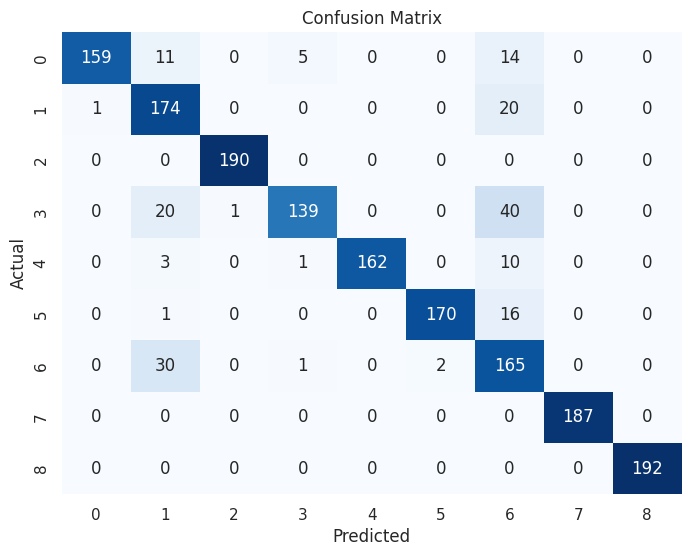

In [ ]:
!pip install seaborn matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Create an AdaBoost classifier with DecisionTree base estimator
ada = AdaBoostClassifier(n_estimators=1000)  # You can adjust parameters as needed

# Train the AdaBoost model
ada.fit(X_train, y_train)

# Predict on the test set
predictions = ada.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, predictions, average='weighted')
print("F1 Score:", f1)

Accuracy: 0.4294049008168028
F1 Score: 0.36571035511586436


## Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Create a voting classifier using the predictions as estimators
voting_classifier = VotingClassifier(estimators=[
    ('nb_gene', MultinomialNB(alpha=0.1, fit_prior= True)),
    ('nb_variation', MultinomialNB(alpha=0.1, fit_prior= True)),
    ('nb_text',MultinomialNB(alpha=0.1, fit_prior= True)),
    ('knn_gene', KNeighborsClassifier()),
    ('knn_variation', KNeighborsClassifier()),
    ('log_gene', LogisticRegression(max_iter=1000, penalty='l2')),
    ('log_variation', LogisticRegression(max_iter=1000, penalty='l2')),
    ('log_text', LogisticRegression(max_iter=1000, penalty='l2')),
    ('sgd_gene', SGDClassifier(max_iter=1000)),
    ('sgd_variation', SGDClassifier(max_iter=1000)),
    ('sgd_text', SGDClassifier(max_iter=1000)),
    ('svm_text', SVC(kernel='linear'))
], voting='hard')

# Fit the Voting Classifier on the second-stage data (X_train)
voting_classifier.fit(X_train, y_train)

# Predict on the second-stage test set (X_test)
predictions = voting_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, predictions)
print("Voting Classifier Accuracy:", accuracy)


Voting Classifier Accuracy: 0.8413068844807468
